In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

In [3]:
import imp, os
print os.getenv('IP_DIFFIM_DIR')+'/tests/testDipoleFitter.py'
dtUtils = imp.load_source('dtUtils', os.getenv('IP_DIFFIM_DIR')+'/tests/testDipoleFitter.py')
from lsst.ip.diffim import dipoleFitTask as dft

/Users/dreiss/GIT_REPOS/ip_diffim/tests/testDipoleFitter.py


In [4]:
import time
print time.strftime("%d.%m.%Y")
print dft.DipoleFitAlgorithm._private_version_

07.04.2016
0.0.5


In [5]:
img = dtUtils.DipoleTestImage(w=51, h=51, flux=[30000.], xcenPos=[27.], ycenPos=[25.], 
                                xcenNeg=[23.], ycenNeg=[25.],
                                gradientParams=(100., 30., 70., 0., 0., 0.))
#dft.DipolePlotUtils.displayExposure(dipole, showPsf=True)
#dft.DipolePlotUtils.displayExposure(posImage, showPsf=True)
#print dipole.getMaskedImage().getArrays()[0].shape
#print dipole.getMaskedImage().getArrays()[2].mean()
#print posImage.getMaskedImage().getArrays()[2].mean()
#print negImage.getMaskedImage().getArrays()[2].mean()

FOOTPRINT CENTER: 25 28
FOOTPRINT CENTER: 25 22



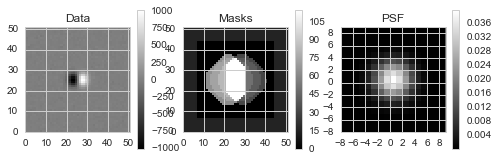

In [6]:
#s = detectDipoleSources(dipole, verbose=False)
s = img.detectDipoleSources(doMerge=True)

for pk in s[0].getFootprint().getPeaks():
    print 'FOOTPRINT CENTER:', pk.getIy(), pk.getIx()

dft.DipolePlotUtils.displayExposure(img.diffim, showPsf=True)
print

(3, 24, 29)



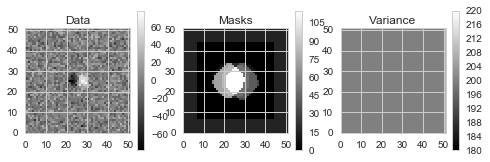

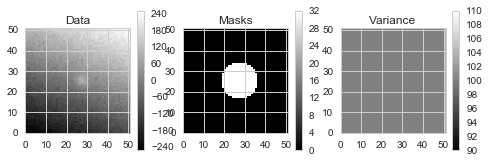

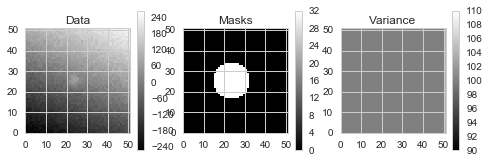

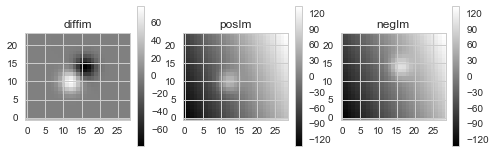

In [7]:
img = dtUtils.DipoleTestImage(w=51, h=51, flux=[2000.], xcenPos=[27.], ycenPos=[25.], 
                                xcenNeg=[23.], ycenNeg=[25.],
                                gradientParams=(1., 3., 7., 0., 0., 0.))
s = img.detectDipoleSources(doMerge=True)

# w, h = diffim.getWidth(), diffim.getHeight()
# print w, h
# y, x = np.mgrid[:w, :h]
# in_x = np.array([x, y])

img.displayImages()
#dft.DipolePlotUtils.displayExposure(diffim)
#dft.DipolePlotUtils.displayExposure(posImage)
#dft.DipolePlotUtils.displayExposure(negImage)

fp = s[0].getFootprint()
psf = img.diffim.getPsf()

alg = dft.DipoleFitAlgorithm(img.diffim, img.posImage, img.negImage)
arr = alg.genDipoleModelImpl(None, flux=2000., xcenPos=23., ycenPos=23., 
                            xcenNeg=27., ycenNeg=27., b=1., x1=3., y1=7., 
                            psf=psf, footprint=fp, rel_weight=0.5)
print arr.shape
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
dft.DipolePlotUtils.display2dArray(arr[0,:], title='diffim')
plt.subplot(1, 3, 2)
dft.DipolePlotUtils.display2dArray(arr[1,:], title='posIm')
plt.subplot(1, 3, 3)
dft.DipolePlotUtils.display2dArray(arr[2,:], title='negIm')
print

1000 loops, best of 3: 364 µs per loop


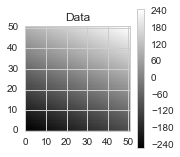

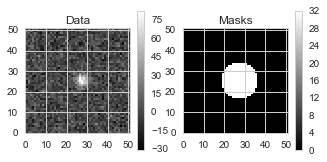

In [17]:
img = dtUtils.DipoleTestImage(w=51, h=51, flux=[2000.], xcenPos=[27.], ycenPos=[25.], 
                                xcenNeg=[23.], ycenNeg=[25.],
                                gradientParams=(1., 3., 7.))
s = img.detectDipoleSources(doMerge=True)
exp = img.posImage
#dft.DipolePlotUtils.displayExposure(exp)

def bgFitAfw(exp, display=False):
    sctrl = afwMath.StatisticsControl()
    sctrl.setNumSigmaClip(3)
    sctrl.setNumIter(4)
    sctrl.setAndMask(afwImage.MaskU.getPlaneBitMask(["INTRP", "EDGE"]))
    sctrl.setNoGoodPixelsMask(afwImage.MaskU.getPlaneBitMask("BAD"))
    sctrl.setNanSafe(True)
    
    bctrl = afwMath.BackgroundControl(6, 6, sctrl)   # number of bins to use
    bkgd = afwMath.makeBackground(exp.getMaskedImage(), bctrl)
    order = 2   # polynomial order of chebyshev polynomial to use
    actrl = afwMath.ApproximateControl(afwMath.ApproximateControl.CHEBYSHEV, order, order)
    approx = bkgd.getApproximate(actrl)
    bim = approx.getImage(order-1)
    if display:
        dft.DipolePlotUtils.displayImage(bim)
        res = img.posImage.clone().getMaskedImage()
        res -= bim
        dft.DipolePlotUtils.displayMaskedImage(res)
    return bim

bim = bgFitAfw(exp, display=True)
%timeit bgFitAfw(exp)

1000 loops, best of 3: 485 µs per loop


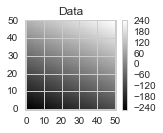

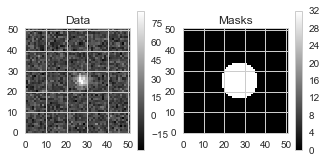

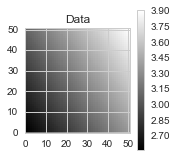

In [18]:
bbox = img.diffim.getBBox()
y, x = np.mgrid[bbox.getBeginY():bbox.getEndY(), bbox.getBeginX():bbox.getEndX()]
in_x = np.array([x, y]).astype(np.float64)
in_x[0, :] -= np.mean(in_x[0, :])
in_x[1, :] -= np.mean(in_x[1, :])

def bgFitCustom(img, in_x, display=False):
    alg = dft.DipoleFitAlgorithm(img.diffim, img.posImage, img.negImage)
    pars1 = alg.fitBackgroundGradient(s[0], img.posImage, order=1)
    #print pars1

    fit1 = alg.genBgGradientModel(in_x, pars1)
    #print fit1.shape, res.getArrays()[0].shape

    if display:
        plt.subplot(3, 3, 1)
        dft.DipolePlotUtils.display2dArray(fit1)
        res = img.posImage.clone().getMaskedImage()
        res.getArrays()[0][:, :] -= fit1
        dft.DipolePlotUtils.displayMaskedImage(res)
    return fit1

fit1 = bgFitCustom(img, in_x, display=True)
tmp = bim.clone()
tmp.getArray()[:, :] -= fit1
dft.DipolePlotUtils.displayImage(tmp)

%timeit bgFitCustom(img, in_x)

 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
[[Model]]
    Model(genDipoleModel)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 2175
    # variables        = 5
    chi-square         = 170571.635
    reduced chi-square = 78.604
    Akaike info crit   = 9502.631
    Bayesian info crit = 9531.055
[[Variables]]
    flux:      1978.33625 +/- 57.71143 (2.92%) (init= 1520.549)
    xcenPos:   27.0755746 +/- 0.099301 (0.37%) (init= 28)
    ycenPos:   24.7891386 +/- 0.083896 (0.34%) (init= 25)
    xcenNeg:   23.0276362 +/- 0.099458 (0.43%) (init= 22)
    ycenNeg:   24.8690397 +/- 0.084442 (0.34%) (init= 25)



/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit/model.py:495: UserWarning: The keyword argument footprint does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit/model.py:495: UserWarning: The keyword argument rel_weight does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit/model.py:495: UserWarning: The keyword argument psf does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)
/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/lmfit/model.py:495: UserWarning: The keyword argument myself does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)



resultsOutput(psfFitPosCentroidX=27.075574619708803, psfFitPosCentroidY=24.789138642905392, psfFitNegCentroidX=23.027636226557917, psfFitNegCentroidY=24.869039749034535, psfFitPosFlux=1978.3362533662171, psfFitNegFlux=-1978.3362533662171, psfFitPosFluxSigma=57.711433228928321, psfFitNegFluxSigma=57.711433228928321, psfFitCentroidX=25.05160542313336, psfFitCentroidY=24.829089195969964, psfFitOrientation=-1.1307982728739878, psfFitSignaltoNoise=31.858960171371045, psfFitChi2=170571.63467387061, psfFitRedChi2=78.604439941875853)
 - Adding parameter "flux"
 - Adding parameter "xcenPos"
 - Adding parameter "ycenPos"
 - Adding parameter "xcenNeg"
 - Adding parameter "ycenNeg"
[[Model]]
    Model(genDipoleModel)
[[Fit Statistics]]
    # function evals   = 39
    # data points      = 725
    # variables        = 5
    chi-square         = 134842.262
    reduced chi-square = 187.281
    Akaike info crit   = 3803.642
    Bayesian info crit = 3826.573
[[Variables]]
    flux:      1869.43774 +/- 

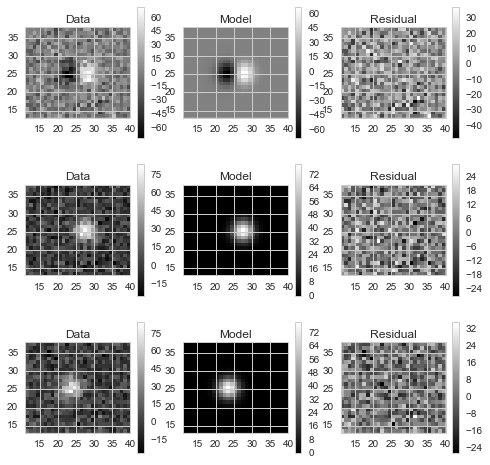

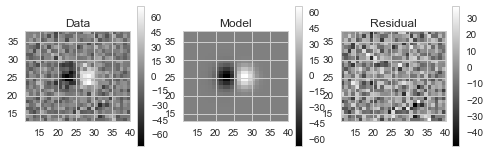

In [10]:
alg = dft.DipoleFitAlgorithm(img.diffim, img.posImage, img.negImage)
result = alg.fitDipole(s[0], verbose=True, 
                        rel_weight=0.5, separateNegParams=False, display=True)
print '\n', result
result = alg.fitDipole(s[0], verbose=True, 
                        rel_weight=0., separateNegParams=False, display=True)
print result

resultsOutput(psfFitPosCentroidX=27.075574619708803, psfFitPosCentroidY=24.789138642905392, psfFitNegCentroidX=23.027636226557917, psfFitNegCentroidY=24.869039749034535, psfFitPosFlux=1978.3362533662171, psfFitNegFlux=-1978.3362533662171, psfFitPosFluxSigma=57.711433228928321, psfFitNegFluxSigma=57.711433228928321, psfFitCentroidX=25.05160542313336, psfFitCentroidY=24.829089195969964, psfFitOrientation=-1.1307982728739878, psfFitSignaltoNoise=31.858960171371045, psfFitChi2=170571.63467387061, psfFitRedChi2=78.604439941875853)
100 loops, best of 3: 14.2 ms per loop
100 loops, best of 3: 11.6 ms per loop
100 loops, best of 3: 16.5 ms per loop
100 loops, best of 3: 12.4 ms per loop


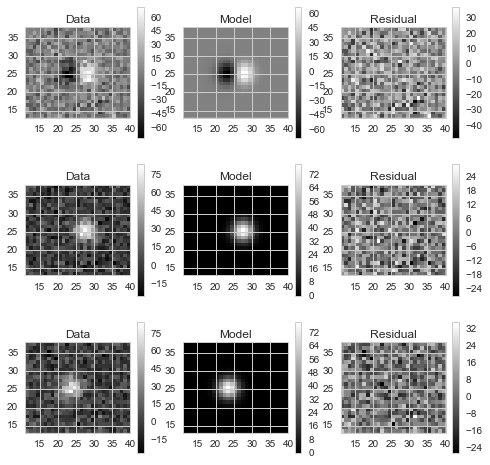

In [11]:
alg = dft.DipoleFitAlgorithm(img.diffim, img.posImage, img.negImage)
result = alg.fitDipole(s[0], rel_weight=0.5,
                        separateNegParams=False, verbose=False, display=True)
print result
%timeit -n 100 alg.fitDipole(s[0], rel_weight=0.5, \
                        separateNegParams=False, verbose=False, display=False)
%timeit -n 100 alg.fitDipole(s[0], rel_weight=0.5, \
                        separateNegParams=False, verbose=False, display=False, tol=1e-5)
%timeit -n 100 alg.fitDipole(s[0], rel_weight=0., \
                        separateNegParams=False, verbose=False, display=False)
%timeit -n 100 alg.fitDipole(s[0], rel_weight=0., \
                        separateNegParams=False, verbose=False, display=False, tol=1e-5)

Old results:
```
100 loops, best of 3: 23.1 ms per loop
100 loops, best of 3: 19.4 ms per loop
100 loops, best of 3: 14.4 ms per loop
100 loops, best of 3: 12.7 ms per loop
```

In [10]:
import line_profiler

def load_ipython_extension(ip):
    ip.define_magic('lprun', line_profiler.magic_lprun)
%load_ext line_profiler

In [14]:
%lprun -f alg.genStarModel alg.fitDipole(s[0], verbose=False, \
                        rel_weight=0.5, separateNegParams=False, display=False)

In [13]:
def sum1(img):
    return np.sum(img.getArray())
sctrl = afwMath.StatisticsControl()
def sum2(img, sctrl):
    stats = afwMath.makeStatistics(img, afwMath.SUM, sctrl)
    return stats.getValue(afwMath.SUM)
img2 = afwImage.ImageF(100, 100)
print sum1(img2)
print sum2(img2, sctrl)
%timeit sum1(img2)
print 'HERE'
%timeit sum2(img2, sctrl)

0.0
0.0
The slowest run took 5.30 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.46 µs per loop
HERE
10000 loops, best of 3: 42 µs per loop


(30, 35)
(580,)
[ -6.56367135e-01   6.99268469e+00   2.99973669e+00  -1.20266684e-02
  -3.74425302e-03  -4.51622756e-03]


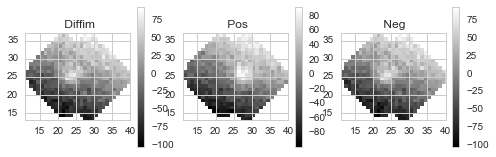

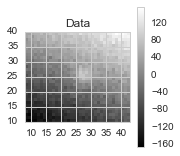

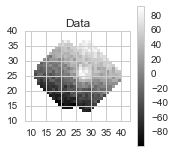

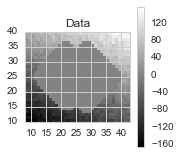

In [19]:
import lsst.afw.detection as afwDet

img.displayCutouts(s[0])
fp = s[0].getFootprint()
bbox = fp.getBBox()
bbox.grow(3)
posImg = afwImage.ImageF(img.posImage.getMaskedImage().getImage(), bbox, afwImage.PARENT)
dtUtils.DipolePlotUtils.displayImage(posImg)
posHfp = afwDet.HeavyFootprintF(fp, img.posImage.getMaskedImage())
posFpImg = dtUtils.DipolePlotUtils.getHeavyFootprintSubimage(posHfp, grow=3)
dtUtils.DipolePlotUtils.displayImage(posFpImg)
isBg = np.isnan(posFpImg.getArray())
print posFpImg.getArray().shape
posBgImg = posImg.clone()
posBgImg.getArray()[~isBg] = 0.
dtUtils.DipolePlotUtils.displayImage(posBgImg)

data = posImg.getArray()
data = data[isBg]
print data.shape

x, y = np.mgrid[bbox.getBeginY():bbox.getEndY(), bbox.getBeginX():bbox.getEndX()]
y = y.astype(np.float64)
y -= y.mean()
y = y[isBg]
x = x.astype(np.float64)
x -= x.mean()
x = x[isBg]
b = np.ones_like(x, dtype=np.float64)

M = np.vstack([b, x, y, x**2., y**2., x*y]).T
#M = np.vstack([b, x, y]).T 
#M = np.vstack([b]).T 

B = data
pars = np.linalg.lstsq(M, B)[0]
print pars

[-2.53675985  6.9916489   3.00063212]
1000 loops, best of 3: 408 µs per loop



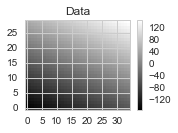

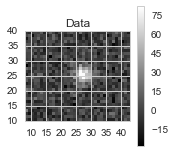

In [20]:
pars = alg.fitBackgroundGradient(s[0], img.posImage)
print pars
%timeit alg.fitBackgroundGradient(s[0], img.posImage)

bbox = s[0].getFootprint().getBBox()
bbox.grow(3)
x, y = np.mgrid[bbox.getBeginY():bbox.getEndY(), bbox.getBeginX():bbox.getEndX()]
in_x = np.array([y, x]).astype(np.float64)
in_x[0, :] -= in_x[0, :].mean()
in_x[1, :] -= in_x[1, :].mean()
pbg = alg.genBgGradientModel(in_x, (pars[0], pars[1], pars[2]))
plt.subplot(3, 3, 1)
dtUtils.DipolePlotUtils.display2dArray(pbg)
pImg = posImg.clone()
pImg.getArray()[:, :] -= pbg
dtUtils.DipolePlotUtils.displayImage(pImg)
print

In [21]:
## I think this is the meat of the ip_diffim code that runs the measurement. 
def measureDipole(s, exposure, dipoleCentroid):
    msConfig = ipDiffim.DipoleMeasurementConfig()
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("centroid_x", type=float)
    schema.addField("centroid_y", type=float)
    schema.addField("centroid_flag", type='Flag')
    task = ipDiffim.DipoleMeasurementTask(schema, config=msConfig)
    measCat = afwTable.SourceCatalog(schema)
    measCat.defineCentroid("centroid")
    source = measCat.addNew()
    source.set("centroid_x", dipoleCentroid[0])
    source.set("centroid_y", dipoleCentroid[1])
    source.setFootprint(s.getFootprint())

    #print 'DIPOLE: ', source.get("classification_dipole") ## from ipDiffim.DipoleMeasurementTask._ClassificationFlag
    # Then run the default SFM task.  Results not checked
    task.run(measCat, exposure)
    return measCat[0] 

#from collections import namedtuple
#resultsOutput = namedtuple('resultsOutput', 
#        #'inputCentroidX inputCentroidY inputSeparation inputRotation inputFlux inputPosCentroidX inputPosCentroidY inputNegCentroidX inputNegCentroidY psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')
#        'psfFitPosCentroidX psfFitPosCentroidY psfFitNegCentroidX psfFitNegCentroidY psfFitPosFlux psfFitNegFlux psfFitCentroidX psfFitCentroidY psfFitOrientation psfFitSignaltoNoise')
resultsOutput = dft.DipoleFitAlgorithm.resultsOutput

def fitDipole_ipDiffim(exposure, sCat):    
    pks = sCat.getFootprint().getPeaks()
    pk1 = pks[0].getF() #)[::-1]  ## need to switch x,y ?? No.
    pk2 = pks[1].getF() #)[::-1]

    dipoleCentroid = (np.int(np.mean([pk1[0], pk2[0]])), np.int(np.mean([pk1[1], pk2[1]])))
    result = measureDipole(sCat, exposure, dipoleCentroid=dipoleCentroid)
    
    ## provides (S/N, position, orientation) of measured dipoles
    dpAnalysis = ipDiffim.DipoleAnalysis()
    sn, centroid, orientation = dpAnalysis(result)

    #rotAngRad = rotAngle / 180. * np.pi
    #xp, yp = xc + separation/2. * np.cos(rotAngRad), yc + separation/2. * np.sin(rotAngRad)
    #xn, yn = xc - separation/2. * np.cos(rotAngRad), yc - separation/2. * np.sin(rotAngRad)
    
    out = resultsOutput(##xc, yc, separation, rotAngle, flux, xp, yp, xn, yn, 
        result.get("ip_diffim_PsfDipoleFlux_pos_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_pos_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_neg_centroid_x"), result.get("ip_diffim_PsfDipoleFlux_neg_centroid_y"),
        result.get("ip_diffim_PsfDipoleFlux_pos_flux"), result.get("ip_diffim_PsfDipoleFlux_neg_flux"),
        0., 0., centroid.getX(), centroid.getY(), orientation, sn, 0., 0.)
    return out

In [22]:
resultsOutput2 = namedtuple('resultsOutput2',
    ['inputCentroidX', 'inputCentroidY', 'inputSeparation', 'inputRotation', 'inputFlux', 'inputPosCentroidX',
     'inputPosCentroidY', 'inputNegCentroidX', 'inputNegCentroidY', 'psfFitPosCentroidX', 'psfFitPosCentroidY',
     'psfFitNegCentroidX', 'psfFitNegCentroidY', 'psfFitPosFlux', 'psfFitNegFlux', 'psfFitCentroidX', 
     'psfFitCentroidY', 'psfFitOrientation', 'psfFitSignaltoNoise'])

def genDipoleAndFitBothWays(w=51, h=51, xc=25., yc=25., separation=2., rotAngle=324., psfSigma=2., 
                            flux=30000., noise=10., rel_weight=0.1, tol=1e-7, 
                            gradientParams=(1., 3., 7., 0., 0., 0.), ## dflt. background gradient params to use for all tests below
                            verbose=False, display=False):

    rotAngRad = rotAngle / 180. * np.pi
    sep = separation / 2.
    xcenPos, ycenPos = xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad)
    xcenNeg, ycenNeg = xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)
    
    img = dtUtils.DipoleTestImage(w=w, h=h, flux=[flux], xcenPos=[xcenPos], ycenPos=[ycenPos], 
                            xcenNeg=[xcenNeg], ycenNeg=[ycenNeg], \
                            psfSigma=psfSigma, noise=noise, \
                            gradientParams=gradientParams)

    resultNA = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                              np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    result1 = result2 = resultNA
    s = None

    try:
        s = img.detectDipoleSources(doMerge=True)
        ## Note that the new code can handle a footprint with a single peak but for better comparison with
        ## old code, let's just raise here.
        #if len(s[0].getFootprint().getPeaks()) <= 1:
        #    raise Exception

    except Exception as err:
        #print 'Uh oh! (1):', err
        return {'old': result2, 'new': result1, 'dipole': img.diffim, 'posImage': img.posImage, 'negImage': img.negImage}
    
    try:
        r1 = fitDipole_ipDiffim(exposure=img.diffim, sCat=s[0])
        result1 = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                            r1.psfFitPosCentroidX, r1.psfFitPosCentroidY, r1.psfFitNegCentroidX,
                            r1.psfFitNegCentroidY, r1.psfFitPosFlux, r1.psfFitNegFlux, r1.psfFitCentroidX,
                            r1.psfFitCentroidY, r1.psfFitOrientation, r1.psfFitSignaltoNoise)
    except Exception as err:
        #print 'Uh oh! (2):', err
        pass
    
    try:
        alg = dft.DipoleFitAlgorithm(img.diffim, img.posImage, img.negImage)
        r2 = alg.fitDipole(s[0], rel_weight=rel_weight,
                            separateNegParams=False, verbose=False, display=False)
        result2 = resultsOutput2(xc, yc, separation, rotAngle, flux, xcenPos, ycenPos, xcenNeg, ycenNeg,
                            r2.psfFitPosCentroidX, r2.psfFitPosCentroidY, r2.psfFitNegCentroidX,
                            r2.psfFitNegCentroidY, r2.psfFitPosFlux, r2.psfFitNegFlux, r1.psfFitCentroidX,
                            r2.psfFitCentroidY, r2.psfFitOrientation, r2.psfFitSignaltoNoise)
    except Exception as err:
        #print 'Uh oh! (3):', err
        pass

    return {'old': result1, 'new': result2, 'dipole': img.diffim, 'posImage': img.posImage, 'negImage': img.negImage}

resultsOutput2(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=324.0, inputFlux=1000.0, inputPosCentroidX=25.809016994374947, inputPosCentroidY=24.412214747707527, inputNegCentroidX=24.190983005625053, inputNegCentroidY=25.587785252292473, psfFitPosCentroidX=25.75721230960503, psfFitPosCentroidY=24.41619550430945, psfFitNegCentroidX=24.200228729382882, psfFitNegCentroidY=25.538515049023314, psfFitPosFlux=1042.6220003639485, psfFitNegFlux=-1039.523828032705, psfFitCentroidX=24.978720519493955, psfFitCentroidY=24.97735527666638, psfFitOrientation=2.19537 rad, psfFitSignaltoNoise=9.5347475095454026)
resultsOutput2(inputCentroidX=25.0, inputCentroidY=25.0, inputSeparation=2.0, inputRotation=324.0, inputFlux=1000.0, inputPosCentroidX=25.809016994374947, inputPosCentroidY=24.412214747707527, inputNegCentroidX=24.190983005625053, inputNegCentroidY=25.587785252292473, psfFitPosCentroidX=25.785756183329429, psfFitPosCentroidY=24.4139972240635, psfFitNegCentroidX=24.

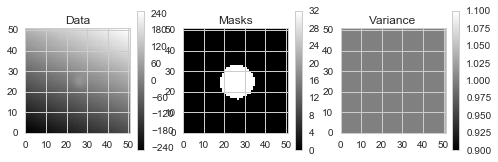

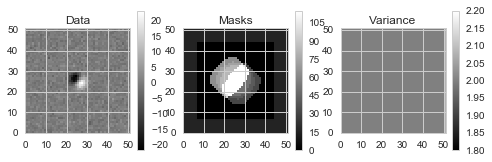

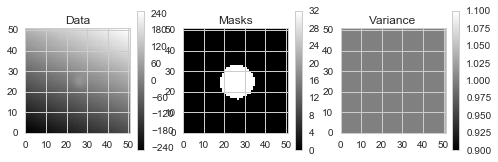

In [23]:
result = genDipoleAndFitBothWays(w=51, h=51, xc=25., yc=25., separation=2., rotAngle=324., psfSigma=2., 
                         flux=1000., noise=1., rel_weight=1.0, verbose=False, display=True)
print result['old']
print result['new']
dft.DipolePlotUtils.displayExposure(result['dipole'])
dft.DipolePlotUtils.displayExposure(result['posImage'])

### First test dipoles of varying separation (same orientation, same flux)

NOTE all of these results below will look better than in `8f.` because we are using `rel_weight = 0.5` by default (instead of `rel_weight = 0.1` in `8g`.

In [24]:
## Is there an easier way to do this (generate named tuple from function variable names)?
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

#orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)[::-1]
n_reps = 100

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=0., \
                   flux=1000., noise=1., tol=1e-7, rel_weight=0.5, verbose=False, display=False, \
                  gradientParams=(1., 3., 7.)) for i in xrange(n_reps) for sep in separations]
print len(inputs)

def processInput(i):
    output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma,
                                     separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                     noise=i.noise, tol=i.tol, rel_weight=i.rel_weight, 
                                     gradientParams=i.gradientParams,
                                     verbose=False, display=False)
    if output['new'] is not None:
        output['new'] = output['new']._asdict()
    if output['old'] is not None:
        output['old'] = output['old']._asdict()
    return {'old': output['old'], 'new': output['new']} ## don't need the images returned

num_cores = multiprocessing.cpu_count() / 2
results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
#results = [processInput(i) for i in inputs]

2400


(22, 28)

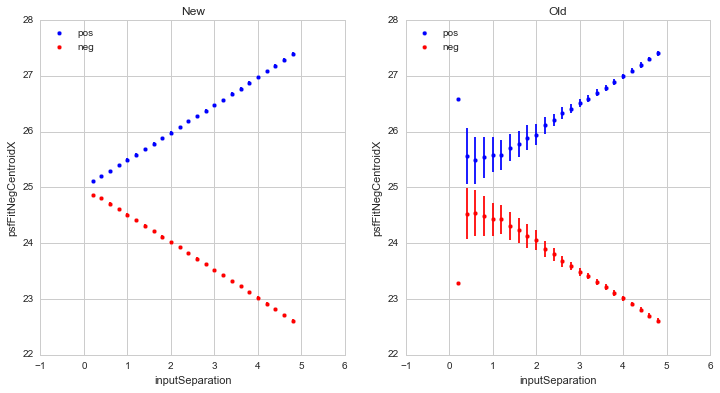

In [25]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidX', kind='scatter', yerr=tmp_df2['psfFitPosCentroidX'], 
                 color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidX', kind='scatter', yerr=tmp_df2['psfFitNegCentroidX'], 
            color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosCentroidX', kind='scatter', yerr=tmp_df2['psfFitPosCentroidX'], 
                 color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='psfFitNegCentroidX', kind='scatter', yerr=tmp_df2['psfFitNegCentroidX'], 
            color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([22,28])
axes[1].set_title('Old')
axes[0].set_ylim([22,28])

(70, 110)

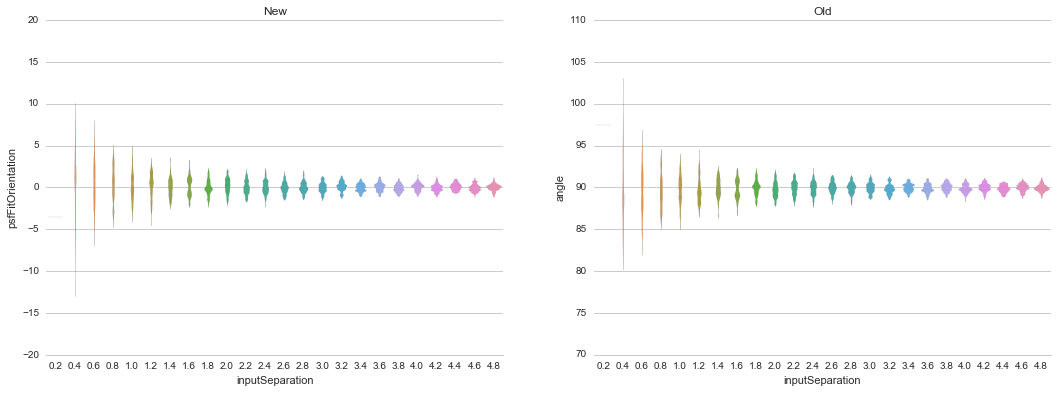

In [26]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
sns.violinplot(x="inputSeparation", y="psfFitOrientation", data=df, inner="quart", cut=True, linewidth=0.1, 
               bw=0.2, ax=axes[0])
sns.despine(left=True)

df = pd.DataFrame([res['old'] for res in results])
df['angle'] = pd.Series([float(i * 180. / np.pi) for i in df.psfFitOrientation])
sns.violinplot(x="inputSeparation", y="angle", data=df, inner="quart", cut=True, linewidth=0.1, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-20,20])
axes[1].set_title('Old')
axes[1].set_ylim([70,110])

(0, 5)

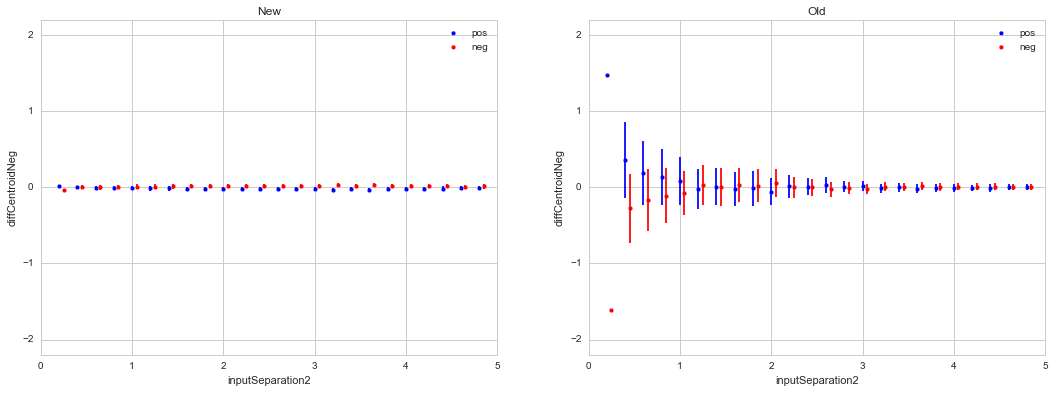

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
df['diffCentroidPos'] = df.psfFitPosCentroidX - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidX - df.inputNegCentroidX
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], 
                 color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation2', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], 
            color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
df['diffCentroidPos'] = df.psfFitPosCentroidX - df.inputPosCentroidX
df['diffCentroidNeg'] = df.psfFitNegCentroidX - df.inputNegCentroidX
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='diffCentroidPos', kind='scatter', yerr=tmp_df2['diffCentroidPos'], 
                 color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation2', y='diffCentroidNeg', kind='scatter', yerr=tmp_df2['diffCentroidNeg'], 
            color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([-2.2,2.2]); axes[0].set_xlim([0,5])
axes[1].set_title('Old')
axes[1].set_ylim([-2.2,2.2]); axes[1].set_xlim([0,5])

(-8000, 8000)

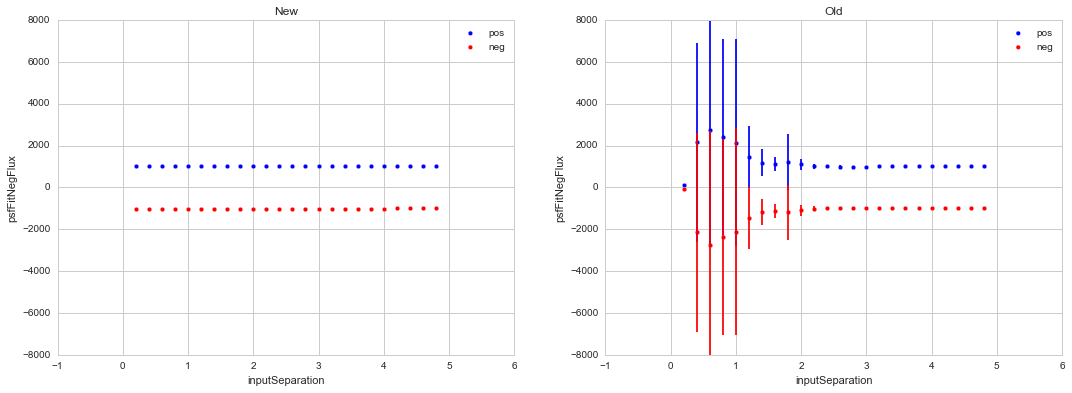

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], 
                 color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], 
            color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results])
tmp_df = df.groupby('inputSeparation').mean()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').std() * 1.
ax = tmp_df.plot(x='inputSeparation', y='psfFitPosFlux', kind='scatter', yerr=tmp_df2['psfFitPosFlux'], 
                 color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation', y='psfFitNegFlux', kind='scatter', yerr=tmp_df2['psfFitNegFlux'], 
            color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([-8000,8000])
axes[1].set_title('Old')
axes[1].set_ylim([-8000,8000])

(-1000, 3000)

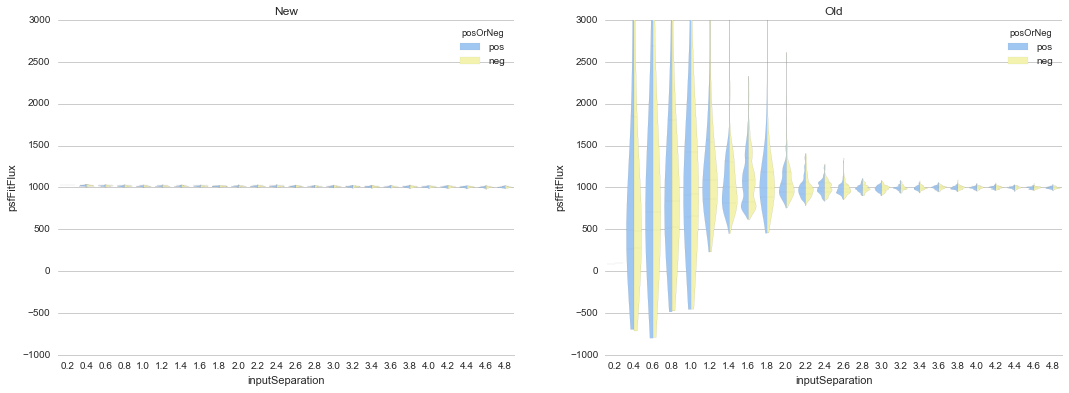

In [29]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.2, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,3000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,3000])

Try it again, this time setting different orientations as well. Next time we'll also test it as a function of scaling (source flux).

## Different orientations AND separations

In [21]:
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
n_reps = 10

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=rot, 
                    flux=1000., noise=1., tol=1e-7, rel_weight=0.5, 
                   gradientParams=(1., 3., 7.), verbose=False, display=False) 
          for i in xrange(n_reps) for rot in orientations for sep in separations]
print len(inputs)

def processInput(i):
    output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma, 
                                     separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                     rel_weight=i.rel_weight, noise=i.noise, tol=i.tol, 
                                     gradientParams=i.gradientParams, verbose=False, display=False)
    if output['new'] is not None:
        output['new'] = output['new']._asdict()
    if output['old'] is not None:
        output['old'] = output['old']._asdict()
    return {'old': output['old'], 'new': output['new']} ## don't need the images returned

num_cores = multiprocessing.cpu_count() / 2
results2 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)
#results2 = [processInput(i) for i in inputs]

2400


(0, 5)

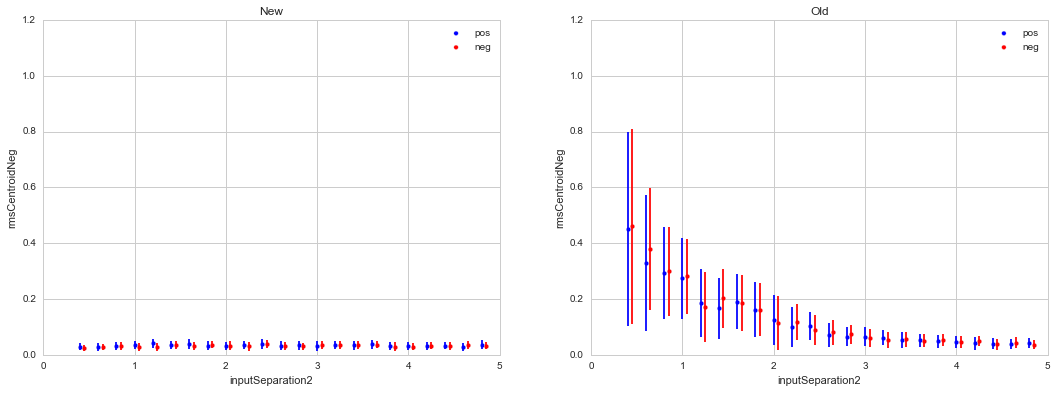

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2)

df = pd.DataFrame([res['new'] for res in results2])
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)

df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], 
                 color='blue', label='pos', ax=axes[0])
tmp_df.plot(x='inputSeparation2', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], 
            color='red', label='neg', ax=ax)

df = pd.DataFrame([res['old'] for res in results2])
df['rmsCentroidPos'] = np.sqrt((df.inputPosCentroidX - df.psfFitPosCentroidX)**2. + \
                               (df.inputPosCentroidY - df.psfFitPosCentroidY)**2.)
df['rmsCentroidNeg'] = np.sqrt((df.inputNegCentroidX - df.psfFitNegCentroidX)**2. + \
                               (df.inputNegCentroidY - df.psfFitNegCentroidY)**2.)
df['inputSeparation2'] = df.inputSeparation + 0.05
tmp_df = df.groupby('inputSeparation').median()
tmp_df['inputSeparation'] = tmp_df.index.values
tmp_df2 = df.groupby('inputSeparation').mad() * 1.
ax = tmp_df.plot(x='inputSeparation', y='rmsCentroidPos', kind='scatter', yerr=tmp_df2['rmsCentroidPos'], 
                 color='blue', label='pos', ax=axes[1])
tmp_df.plot(x='inputSeparation2', y='rmsCentroidNeg', kind='scatter', yerr=tmp_df2['rmsCentroidNeg'], 
            color='red', label='neg', ax=ax)

axes[0].set_title('New')
axes[0].set_ylim([0.,1.2]); axes[0].set_xlim([0, 5])
axes[1].set_title('Old')
axes[1].set_ylim([0.,1.2]); axes[1].set_xlim([0, 5])

(-0.1, 2.0)

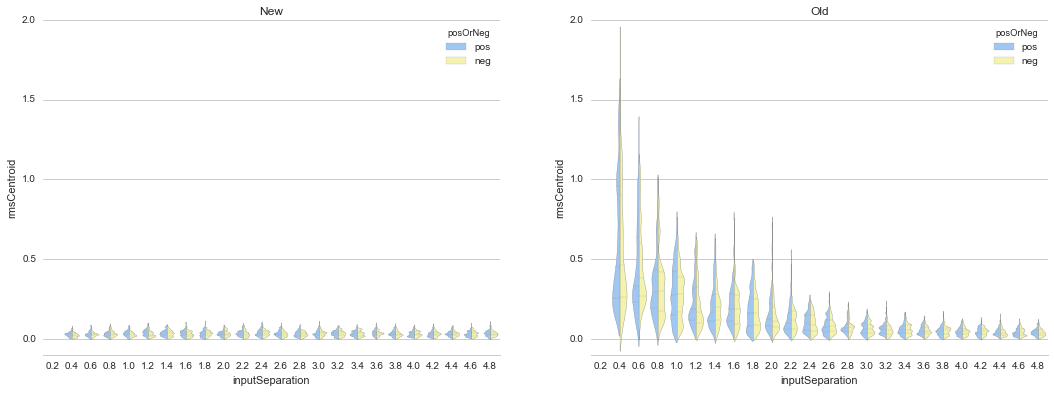

In [23]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results2])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results2])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-0.1,2.0])
axes[1].set_title('Old')
axes[1].set_ylim([-0.1,2.0])

(-1000, 3000)

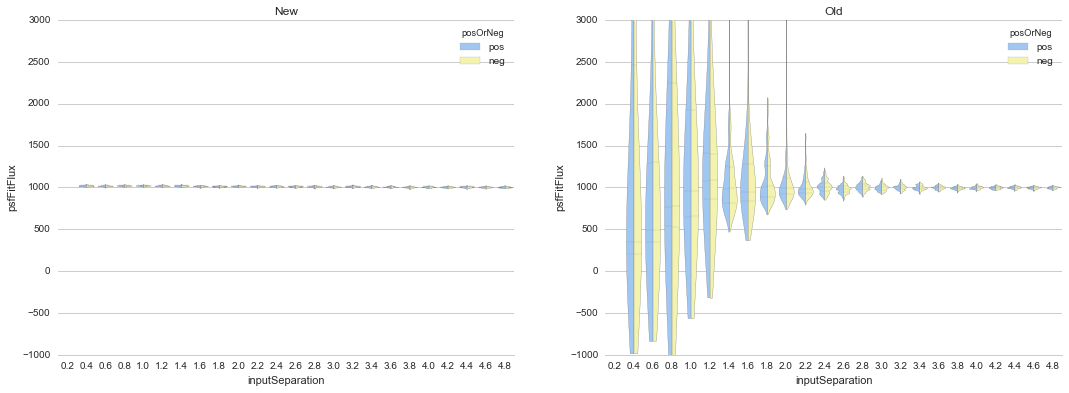

In [24]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results2])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results2])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.3, bw=0.2, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,3000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,3000])

## Different dipole fluxes (signal-to-noise) AND orientations AND separations

In [26]:
varNames = genDipoleAndFitBothWays.__code__.co_varnames[:genDipoleAndFitBothWays.__code__.co_argcount]
varTuple = namedtuple("varTuple", varNames)

orientations = np.arange(0.0, 360.0, 36.0)
separations = np.arange(0.2, 5.0, 0.2)
fluxes = np.arange(250., 6000., 250.)
n_reps = 10

inputs = [varTuple(w=51, h=51, xc=25., yc=25., psfSigma=2.0, separation=sep, rotAngle=rot, 
                    flux=flux, noise=1., tol=1e-7, rel_weight=0.5, 
                   gradientParams=(1., 3., 7.), verbose=False, display=False) 
                for i in xrange(n_reps) for flux in fluxes for rot in orientations for sep in separations]
print len(inputs)

def processInput(i):
    output = genDipoleAndFitBothWays(w=i.w, h=i.h, xc=i.xc, yc=i.yc, psfSigma=i.psfSigma, 
                                     separation=i.separation, rotAngle=i.rotAngle, flux=i.flux, 
                                     noise=i.noise, tol=i.tol, rel_weight=i.rel_weight, 
                                     gradientParams=i.gradientParams, verbose=False, display=False)
    if output['new'] is not None:
        output['new'] = output['new']._asdict()
    if output['old'] is not None:
        output['old'] = output['old']._asdict()
    return {'old': output['old'], 'new': output['new']} ## don't need the images returned
 
num_cores = multiprocessing.cpu_count() / 2
#results3 = [processInput(i) for i in inputs]
results3 = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in inputs)

55200


In [27]:
## NOT RUN:
#if False:
import cPickle as pickle
import gzip
pickle.dump((results, results2, results3), gzip.GzipFile("results_10.p.gz", "wb"))

(-0.05, 0.8)

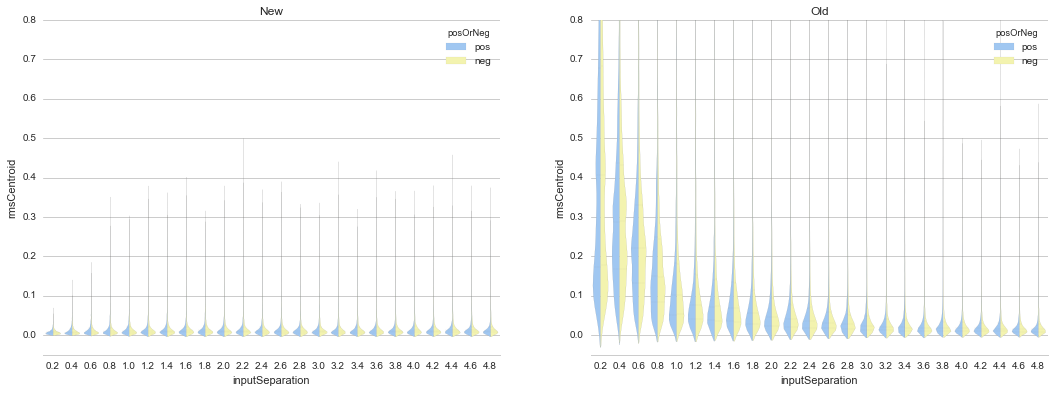

In [27]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['rmsCentroid'] = np.sqrt((df1.inputPosCentroidX - df1.psfFitPosCentroidX)**2. + \
                               (df1.inputPosCentroidY - df1.psfFitPosCentroidY)**2.)   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['rmsCentroid'] = np.sqrt((df2.inputNegCentroidX - df2.psfFitNegCentroidX)**2. + \
                               (df2.inputNegCentroidY - df2.psfFitNegCentroidY)**2.)   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="rmsCentroid", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, linewidth=0.1, bw=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-0.05,0.8])
axes[1].set_title('Old')
axes[1].set_ylim([-0.05,0.8])

(-1000, 15000)

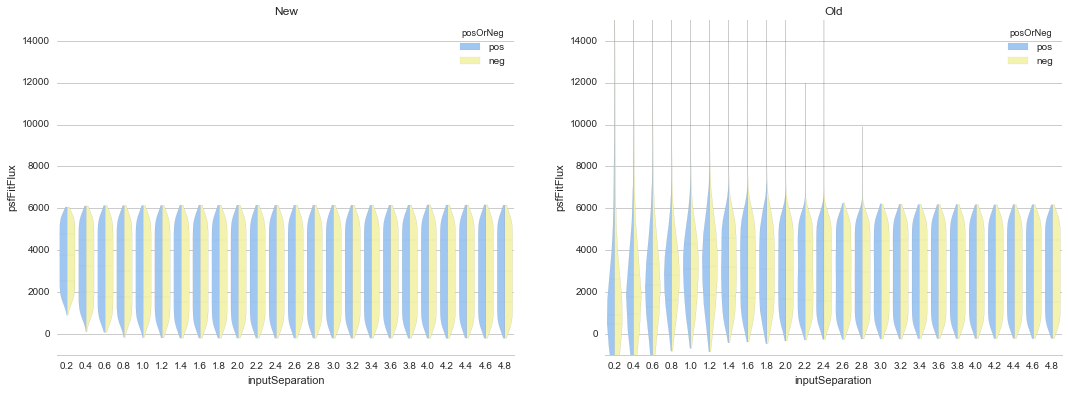

In [28]:
##### matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
#df1 = df1.loc[(df1.inputFlux == 5000.)]
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
#df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
#df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputSeparation", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.25, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([-1000,15000])
axes[1].set_title('Old')
axes[1].set_ylim([-1000,15000])

(0, 7000)

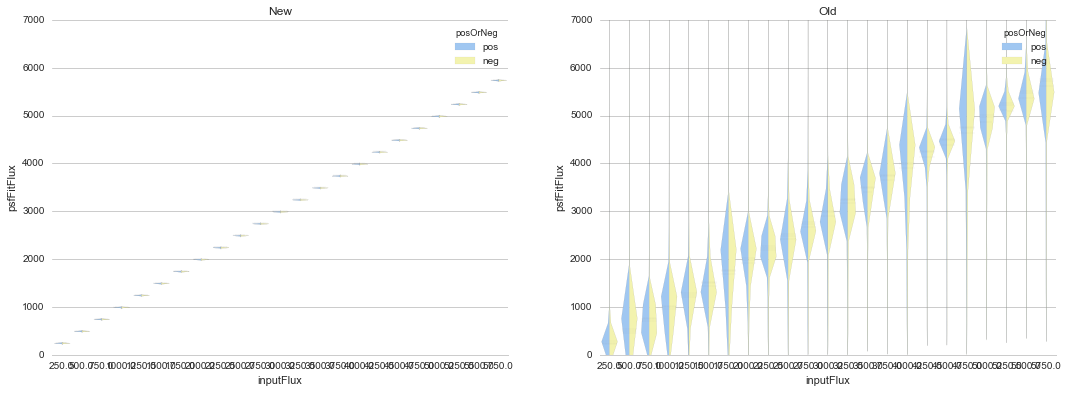

In [29]:
matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
fig, axes = plt.subplots(nrows=1, ncols=2)

df1 = pd.DataFrame([res['new'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.1, linewidth=0.1, ax=axes[0])
sns.despine(left=True)

df1 = pd.DataFrame([res['old'] for res in results3])
df2 = df1.copy()
df1['psfFitFlux'] = df1.psfFitPosFlux   # positive
#df1.loc[(df1.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df1['posOrNeg'] = np.repeat('pos', df1.shape[0])
df2['psfFitFlux'] = -df2.psfFitNegFlux   # negative
#df2.loc[(df2.psfFitFlux > 30000.), 'psfFitFlux'] = 30000.
df2['posOrNeg'] = np.repeat('neg', df2.shape[0])
sns.violinplot(x="inputFlux", y="psfFitFlux", hue="posOrNeg", data=df1.append(df2), split=True,
               inner="quart", palette={"pos": "b", "neg": "y"}, cut=True, bw=0.1, linewidth=0.1, ax=axes[1])
sns.despine(left=True)

axes[0].set_title('New')
axes[0].set_ylim([0,7000])
axes[1].set_title('Old')
axes[1].set_ylim([0,7000])

(-100, 6500)

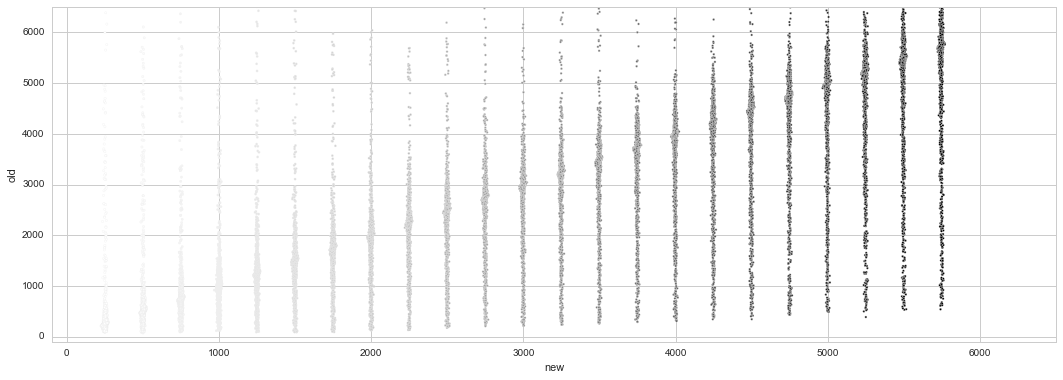

In [30]:
df1 = pd.DataFrame([res['new'] for res in results3])
df2 = pd.DataFrame([res['old'] for res in results3])
df = pd.DataFrame({'new': df1['psfFitPosFlux'], 'old': df2['psfFitPosFlux'], 'fl': df1['inputFlux']})
df = df[(df['new'] != np.inf) & (df['old'] != np.inf)] # & (df['sn1'] < 30000.) & (df['sn2'] < 30000.)]
ax = df.plot(x='new', y='old', kind='scatter', c=df['fl']/df['fl'].max(), s=5.)
ax.set_xlim([-100,6500])
ax.set_ylim([-100,6500])

(-0.5, 3.0)

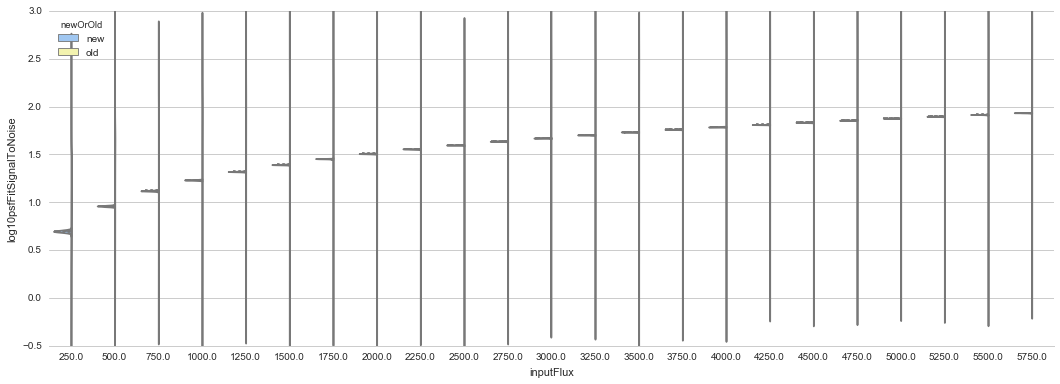

In [30]:
df = pd.DataFrame([res['new'] for res in results3])
df['newOrOld'] = np.repeat('new', df.shape[0])
df['log10psfFitSignalToNoise'] = np.log10(df['psfFitSignaltoNoise'])
df = df[(df.log10psfFitSignalToNoise != np.inf) & (df.log10psfFitSignalToNoise != np.nan) & (df.log10psfFitSignalToNoise < 8000.)]

df2 = pd.DataFrame([res['old'] for res in results3])
df2['newOrOld'] = np.repeat('old', df2.shape[0])
df2['log10psfFitSignalToNoise'] = np.log10(df2['psfFitSignaltoNoise'])
df2 = df2[(np.abs(df2.log10psfFitSignalToNoise) != np.inf) & (df2.log10psfFitSignalToNoise != np.nan) & (df2.log10psfFitSignalToNoise < 8000.)]

df = df.append(df2)

matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
#fig, axes = plt.subplots(nrows=1, ncols=2)
fig = plt.figure()
ax = fig.add_subplot(111)

sns.violinplot(x="inputFlux", y="log10psfFitSignalToNoise", hue="newOrOld", data=df, split=True,
               inner="quart", palette={"new": "b", "old": "y"}, cutoff=True, bw=0.2, axis=ax)
sns.despine(left=True)
ax.set_ylim([-0.5,3.])

## Investigate error contours by including (or not) the pre-subtracted image planes in the fit and including (or not) the background gradients

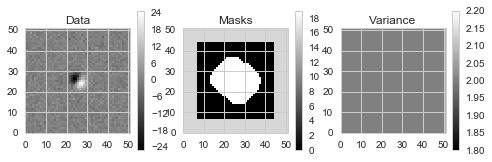

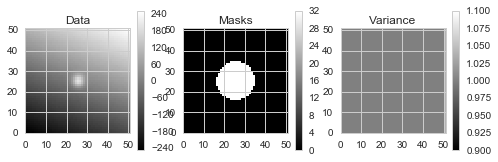

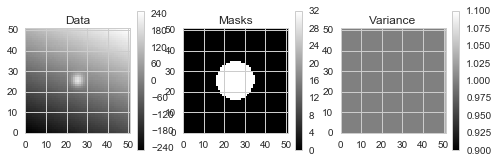

In [36]:
xc=25.; yc=25.; separation=0.4; rotAngle=324.

rotAngRad = rotAngle / 180. * np.pi
sep = separation / 2.
xcenPos, ycenPos = xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad)
xcenNeg, ycenNeg = xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad)

img = dtUtils.DipoleTestImage(w=51, h=51, xcenPos=[xcenPos], ycenPos=[ycenPos], \
                         xcenNeg=[xcenNeg], ycenNeg=[ycenNeg], \
                         psfSigma=2., flux=[5000.], noise=1., \
                         gradientParams=(1., 3., 7.))
img.displayImages()

s = img.detectDipoleSources(doMerge=True)

### Plot confidence intervals...

see https://lmfit.github.io/lmfit-py/confidence.html

In [37]:
## hide warnings for this fit.
import warnings
warnings.filterwarnings('ignore')

import lmfit

def plot_conf_intervals(result):
    ci, trace = lmfit.conf_interval(result, result, sigmas=[0.68,0.95],
                                    trace=True, verbose=False)
    lmfit.printfuncs.report_ci(ci)

    matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
    cx, cy, grid = lmfit.conf_interval2d(result, result, 'xcenPos','flux', 30, 30)
    plt.subplot(1, 2, 1)
    plt.contourf(cx, cy, grid, np.linspace(0,1,100))
    plt.xlabel('xcenPos')
    plt.ylabel('flux')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    cx, cy, grid = lmfit.conf_interval2d(result, result, 'xcenPos','ycenPos', 30, 30)
    plt.contourf(cx, cy, grid, np.linspace(0,1,100))
    plt.xlabel('xcenPos')
    plt.ylabel('ycenPos')
    plt.colorbar() 

First, don't include pre-subtracted data (weight=0)

            95.00%    68.00%    _BEST_    68.00%    95.00%
 flux   :-1759.00077-1223.662733385.08113+6711.45560      +inf
 xcenPos:  -0.29073  -0.16590  25.22137  +0.14079  +0.27032
 ycenPos:  -0.20740  -0.10664  24.79693  +0.12121  +0.21806
 xcenNeg:  -0.26515  -0.13623  24.74681  +0.15579  +0.27629
 ycenNeg:  -0.23211  -0.12873  25.15820  +0.11080  +0.21332


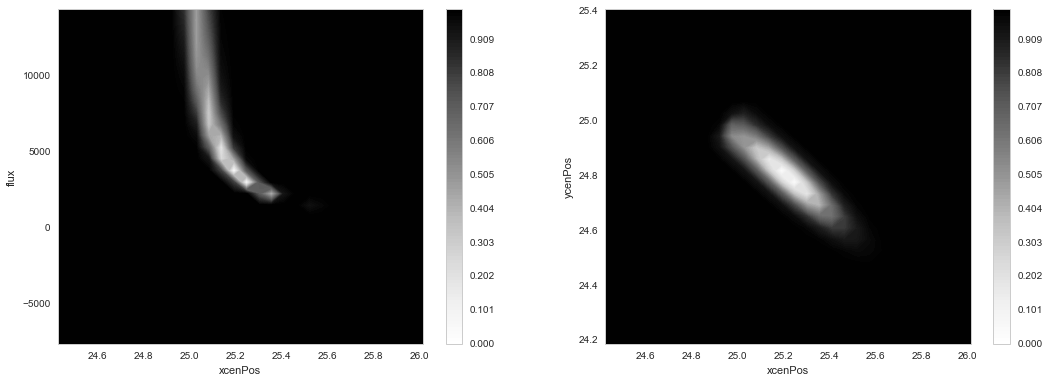

In [38]:
alg = dft.DipoleFitAlgorithm(img.diffim, img.posImage, img.negImage)
_, result0 = alg.fitDipole(s[0], tol=1e-7, rel_weight=0.,
                           separateNegParams=False, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result0)

Now, with the pre-subtraction data weighted at 5% of the subtracted data:

            95.00%    68.00%    _BEST_    68.00%    95.00%
 flux   :-156.18197 -79.192764989.79550 +79.45973+156.45663
 xcenPos:  -0.03599  -0.01872  25.19906  +0.01744  +0.03539
 ycenPos:  -0.03739  -0.01920  24.89349  +0.01920  +0.03739
 xcenNeg:  -0.03614  -0.01758  24.87585  +0.01757  +0.03577
 ycenNeg:  -0.03856  -0.01918  25.12858  +0.01913  +0.03730


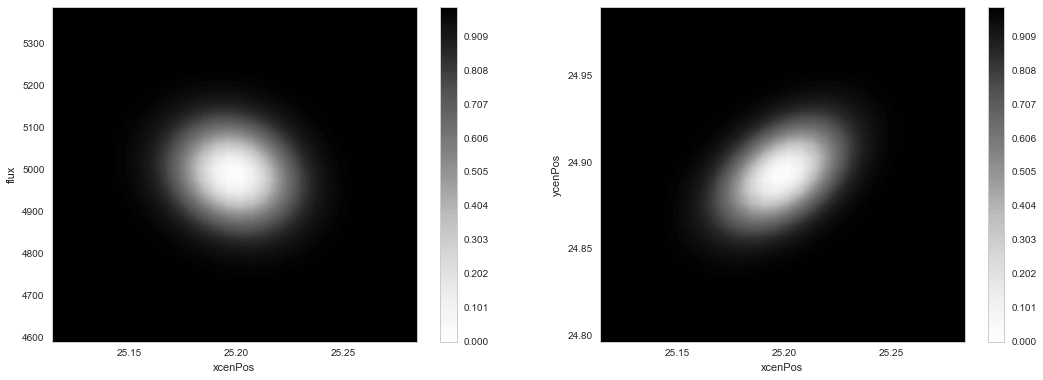

In [12]:
_, result1 = alg.fitDipole(s[0], tol=1e-7, rel_weight=0.05, 
                           separateNegParams=False, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result1)

Finally with the pre-subtraction data weighted equally with the diffim data...

            95.00%    68.00%    _BEST_    68.00%    95.00%
 flux   : -17.56829  -8.913694994.73172  +8.93546 +17.56651
 xcenPos:  -0.01036  -0.00548  25.16583  +0.00547  +0.01036
 ycenPos:  -0.01048  -0.00553  24.88146  +0.00554  +0.01048
 xcenNeg:  -0.01037  -0.00547  24.84280  +0.00548  +0.01037
 ycenNeg:  -0.01048  -0.00552  25.11635  +0.00553  +0.01048


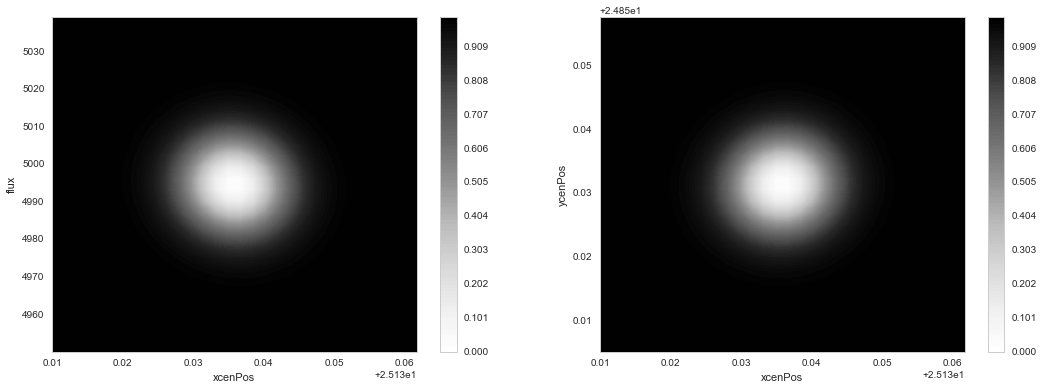

In [13]:
_, result2 = alg.fitDipole(s[0], tol=1e-7, rel_weight=0.5, 
                           separateNegParams=False, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result2)

Lastly with the pre-subtraction data weighted 1/20 $\times$ the diffim data but no background gradient included in the fits. Note we include a background constant just because we need it.

            95.00%    68.00%    _BEST_    68.00%    95.00%
 flux   :-554.32626-281.153824830.39377+281.38760+554.75563
 xcenPos:  -0.12190  -0.06175  25.27445  +0.05902  +0.11329
 ycenPos:  -0.13400  -0.06766  24.99678  +0.06780  +0.13275
 xcenNeg:  -0.12512  -0.06312  24.94169  +0.06162  +0.11822
 ycenNeg:  -0.13013  -0.06557  25.23824  +0.06520  +0.12684


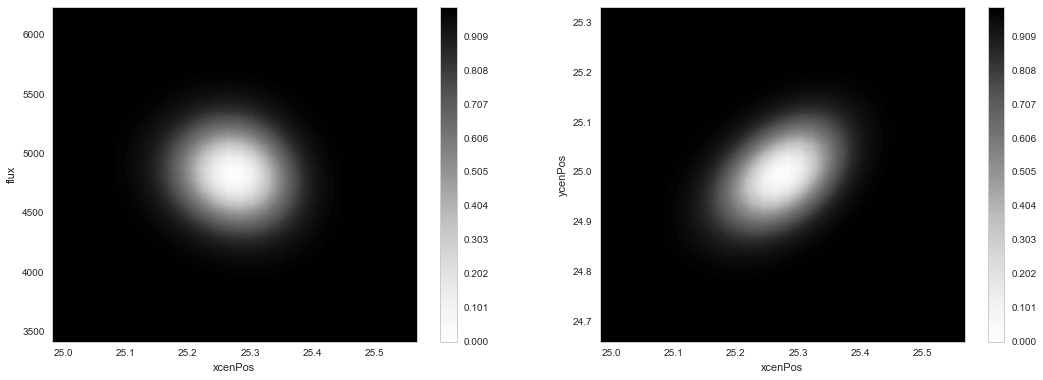

In [14]:
_, result3 = alg.fitDipole(s[0], tol=1e-7, rel_weight=0.05, 
                           separateNegParams=False, bgGradientOrder=0, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result3)

Lastly with the pre-subtraction data weighted 1/2 $\times$ (standard) the diffim data but no background gradient included in the fits. Note we include a background constant just because we need it.

            95.00%    68.00%    _BEST_    68.00%    95.00%
 flux   :-249.25787-126.727001009.79853+126.76408+249.32532
 xcenPos:  -3.13501  -1.36212  36.96654      +inf      +inf
 ycenPos:  -0.84908  -0.22485  32.99859      +inf      +inf
 xcenNeg:  -0.84924  -0.42000  24.10458  +0.48418  +0.93218
 ycenNeg:  -0.90616  -0.48293  26.28203  +0.48285  +0.95472


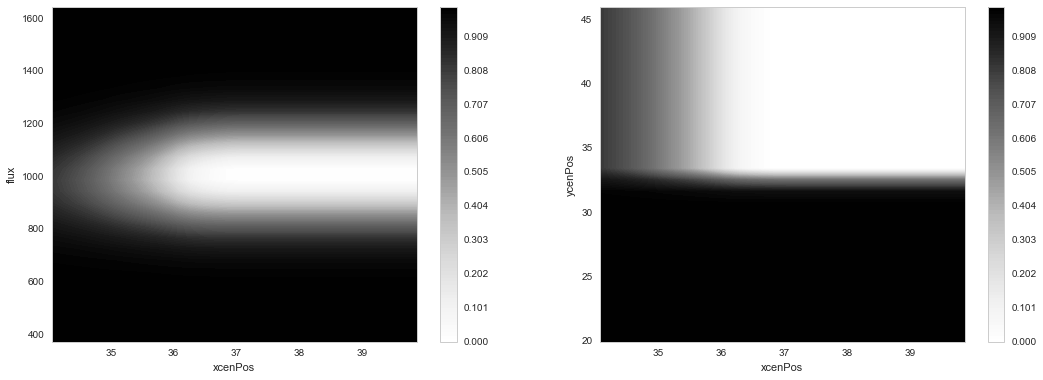

In [17]:
_, result4 = alg.fitDipole(s[0], tol=1e-7, rel_weight=0.5, 
                           separateNegParams=False, bgGradientOrder=0, verbose=False, display=False, return_fitObj=True)
plot_conf_intervals(result4)